## 0. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from interpret_extension import show
from interpret_extension.glassbox import NAMClassifier

c:\Users\javip\anaconda3\envs\testing-interpret\lib\site-packages\interpret_extension\glassbox\_nam\trainer\trainer.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## 1. Loading Diabetes Dataset

We will use a diabetes dataset, which consists in several columns and one target feature: if the patient has diabetes or not.

In [2]:
X_train = pd.read_csv('data/diabetes/X_train.csv')
y_train = pd.read_csv('data/diabetes/y_train.csv').to_numpy().ravel()

X_test = pd.read_csv('data/diabetes/X_test.csv')
y_test = pd.read_csv('data/diabetes/y_test.csv').to_numpy().ravel()

In [3]:
print(X_train.columns.to_list())

['pregnancies', 'glucose', 'diastolic', 'triceps', 'insulin', 'bmi', 'dpf', 'age']


In [4]:
X_train.head(3)

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age
0,7,150,78,29,126,35.2,0.692,54
1,4,97,60,23,0,28.2,0.443,22
2,0,165,90,33,680,52.3,0.427,23


In [5]:
print("Percentage of positive class in training data: ", y_train[y_train == 1].shape[0] / y_train.shape[0])
print("Percentage of positive class in test data: ", y_test[y_test == 1].shape[0] / y_test.shape[0])
print()
print("Percentage of negative class in training data: ", y_train[y_train == 0].shape[0] / y_train.shape[0])
print("Percentage of negative class in test data: ", y_test[y_test == 0].shape[0] / y_test.shape[0])

Percentage of positive class in training data:  0.35993485342019543
Percentage of positive class in test data:  0.3051948051948052

Percentage of negative class in training data:  0.6400651465798045
Percentage of negative class in test data:  0.6948051948051948


## 2. NAM Model

NAM is a type of GAM (Generalized Additive Model) architecture based on neural networks. This model uses one neural network for each feature, making it additive and allowing it to be interpretable.

In [6]:
model = NAMClassifier(
            num_epochs=50, 
            num_learners=5, # Number of learners 
            metric='accuracy',
            early_stop_mode='max',
            monitor_loss=False,
            n_jobs=1,
            random_state=42
        )

Let's fit it:

In [7]:
model.fit(X_train, y_train)

Epoch(0):      | 0/50 [00:00<?, ?it/s]
                    Training Loss: 1.140 |
Epoch(0):           Validation Loss: 11.418 | ACCURACY: 0.179:   0%|          | 0/50 [00:00<?, ?it/s]
                    Training Loss: 1.140 |
Epoch(1):           Validation Loss: 11.418 | ACCURACY: 0.179:   2%|▏         | 1/50 [00:00<00:13,  3.51it/s]
                    Training Loss: 18.293 |
Epoch(2):           Validation Loss: 3.084 | ACCURACY: 0.132:   2%|▏         | 1/50 [00:00<00:13,  3.51it/s]
                    Training Loss: 4.345 |
Epoch(2):           Validation Loss: 2.126 | ACCURACY: 0.251:   2%|▏         | 1/50 [00:00<00:13,  3.51it/s] 
                    Training Loss: 4.345 |
Epoch(3):           Validation Loss: 2.126 | ACCURACY: 0.251:   6%|▌         | 3/50 [00:00<00:05,  7.89it/s]
                    Training Loss: 3.024 |
Epoch(4):           Validation Loss: 1.002 | ACCURACY: 0.054:   6%|▌         | 3/50 [00:00<00:05,  7.89it/s]
                    Training Loss: 1.482 |
Epoch(4): 

As we see, five different models have been trained (**num_learners**). The predictions will be the result of the mean of each one of them.

In [8]:
print("Number of models:", len(model.models))
model.models[0]

Number of models: 5


NAM(
  (dropout_layer): Dropout(p=0.05, inplace=False)
  (feature_nns): ModuleList(
    (0): FeatureNN(
      (dropout): Dropout(p=0.1, inplace=False)
      (model): ModuleList(
        (0): LinReLU(in_features=1, out_features=34)
        (1): Linear(in_features=34, out_features=64, bias=True)
        (2): ReLU()
        (3): Linear(in_features=64, out_features=32, bias=True)
        (4): ReLU()
        (5): Linear(in_features=32, out_features=1, bias=False)
      )
    )
    (1-7): 7 x FeatureNN(
      (dropout): Dropout(p=0.1, inplace=False)
      (model): ModuleList(
        (0): LinReLU(in_features=1, out_features=64)
        (1): Linear(in_features=64, out_features=64, bias=True)
        (2): ReLU()
        (3): Linear(in_features=64, out_features=32, bias=True)
        (4): ReLU()
        (5): Linear(in_features=32, out_features=1, bias=False)
      )
    )
  )
)

Let's predict:

In [9]:
pred = model.predict(X_test)
print("Accuracy: ", np.mean(pred == y_test))

Accuracy:  0.6745656940462136


The original implementation had some interesting plots:

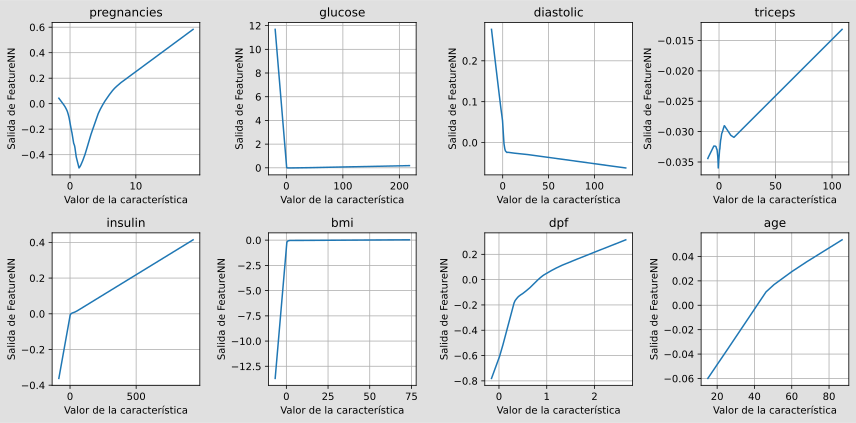

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for i in range(8):
    plot = model.plot(i)
    x = plot['x']
    y = plot['y']
    conf_int = plot['conf_int']    

    ax = axes[i]
    ax.plot(x, y)

    ax.set_xlabel("Valor de la característica")
    ax.set_ylabel("Salida de FeatureNN")
    ax.set_title(X_train.columns[i])
    ax.grid(True)
    
plt.tight_layout()
plt.show()

However, let's see each one of them with the InterpretML interface:

In [11]:
nam_global = model.explain_global()
show(nam_global)

<!-- http://127.0.0.1:7656/1956433886368/ -->

And of course the local explanations:

In [12]:
nam_local = model.explain_local(X_test, y_test)
show(nam_local)

<!-- http://127.0.0.1:7656/1956557514656/ -->